# Import Package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime
import math
import pickle

# Define Functions

In [3]:
def Average(data):
    return sum(data) / len(data)

def convert_bit_lenght(data):        
    a = []
    for element in data:
        native_int = int(element)
        a.append(native_int.bit_length())
    return a

def normalize_series(data, mean, std):
    data = data - mean
    data = data / std
    return data

def inverse_normalize_series(data, mean, std):
    data = data * std
    data = data + mean
    return data

# Read Dataset

In [4]:
data = pd.read_excel('ready_data_pax_bms 1 April - 19 Juli 2023.xlsx', index_col='Unnamed: 0')
data

DATE  PAX_BMS_T1  PAX_BMS_T2  PAX_BMS_T3
0    2023-04-01 00:00:00           0           8           0
1    2023-04-01 01:00:00           0           0           0
2    2023-04-01 02:00:00           0           0           0
3    2023-04-01 03:00:00           0           0           0
4    2023-04-01 04:00:00           0           0           0
...                  ...         ...         ...         ...
2635 2023-07-19 19:00:00          73         119          65
2636 2023-07-19 20:00:00          69          92          90
2637 2023-07-19 21:00:00          28          25          47
2638 2023-07-19 22:00:00           2           9          31
2639 2023-07-19 23:00:00           1           3           4

[2640 rows x 4 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 0 to 2639
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        2640 non-null   datetime64[ns]
 1   PAX_BMS_T1  2640 non-null   int64         
 2   PAX_BMS_T2  2640 non-null   int64         
 3   PAX_BMS_T3  2640 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 103.1 KB


In [6]:
data.describe()

DATE   PAX_BMS_T1   PAX_BMS_T2   PAX_BMS_T3
count                 2640  2640.000000  2640.000000  2640.000000
mean   2023-05-25 23:30:00    36.214773    75.382197    57.459470
min    2023-04-01 00:00:00     0.000000     0.000000     0.000000
25%    2023-04-28 11:45:00     0.000000     4.750000     2.000000
50%    2023-05-25 23:30:00    27.000000    69.000000    57.000000
75%    2023-06-22 11:15:00    65.000000   127.000000    96.000000
max    2023-07-19 23:00:00   194.000000   394.000000   227.000000
std                    NaN    36.695872    69.154799    50.794938

# Split data to training, validation and testing

split data with proportion 65% for training data, 30% for validation data and 5% for testing

In [7]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [8]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.65*((len(data))/24)) * 24) 
print(f'jumlah data training: {SPLIT_TIME_TRAIN_REM}')

jumlah data training: 1704


In [9]:
data_train = data[:SPLIT_TIME_TRAIN_REM]['PAX_BMS_T3']
data_train = pd.DataFrame(data_train)
data_train.index = data[:SPLIT_TIME_TRAIN_REM]['DATE']

data_rem = data[SPLIT_TIME_TRAIN_REM:]['PAX_BMS_T3']
data_rem = pd.DataFrame(data_rem)
data_rem.index = data[SPLIT_TIME_TRAIN_REM:]['DATE']

In [10]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.87*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST
print(f'jumlah data validation: {SPLIT_TIME_VAL_TEST}')
print(f'jumlah data validation: {len(data_rem) - SPLIT_TIME_VAL_TEST}')

jumlah data validation: 792
jumlah data validation: 144


In [11]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [12]:
# % of training set
print(f'data training -> {(len(data_train)/len(data)) * 100}%')
print(f'data validation -> {(len(data_val)/len(data)) * 100}%')
print(f'data testing -> {(len(data_test)/len(data)) * 100}%')

data training -> 64.54545454545455%
data validation -> 30.0%
data testing -> 5.454545454545454%


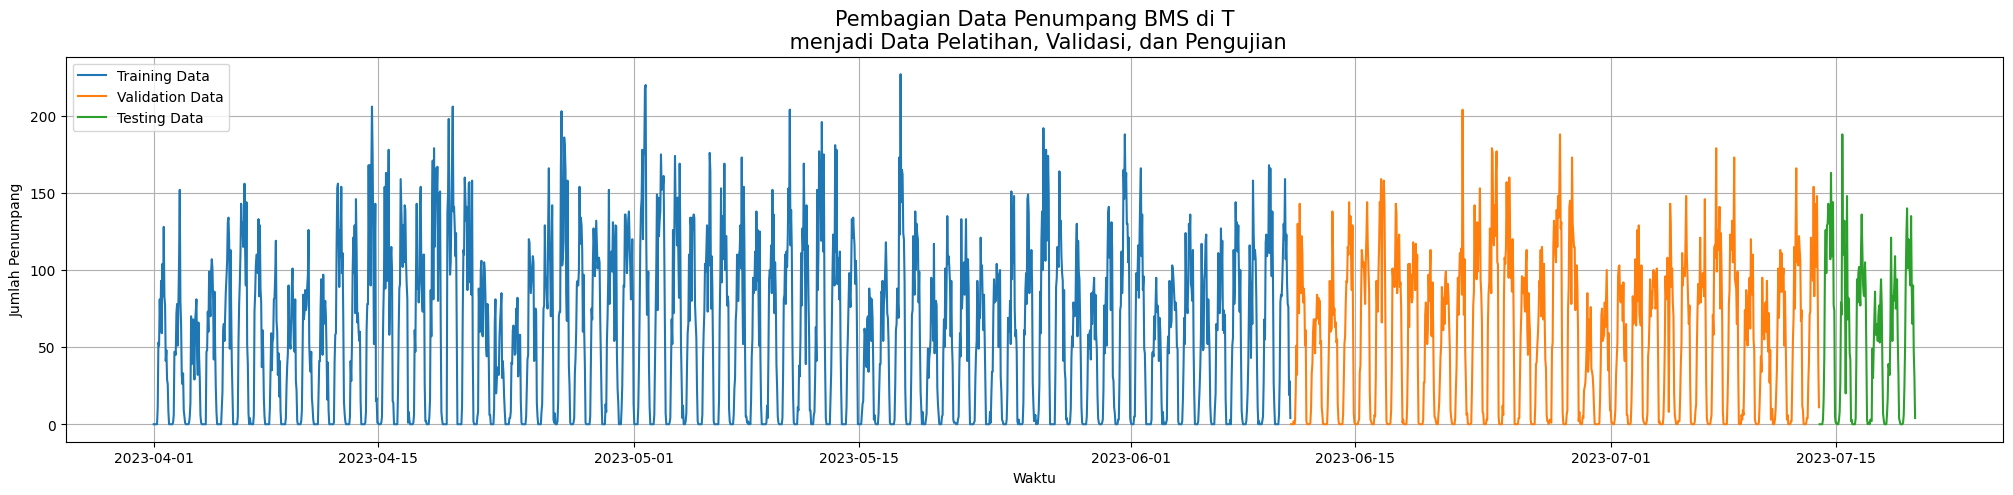

In [13]:
plt.subplots(figsize=(25, 5))
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_train, label='Training Data')
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_val, label='Validation Data')
sns.lineplot(x="DATE", y="PAX_BMS_T3",
             data=data_test, label='Testing Data')
plt.xlabel('Waktu'); plt.ylabel('Jumlah Penumpang')
plt.title("Pembagian Data Penumpang BMS di T\n menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 15)
plt.grid()
plt.legend(loc='upper left')

## check sequence data

In [14]:
paxT3 = data["PAX_BMS_T3"].values.reshape(-1, 1)

paxT3_train = data_train.values.reshape(-1, 1)

paxT3_val = data_val.values.reshape(-1, 1)

paxT3_test = data_test.values.reshape(-1, 1)

print(paxT3_train.shape);print(paxT3_val.shape)

(1704, 1)
(792, 1)


In [15]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxT3_train) - n_forecast + 1):
    x_train.append(paxT3_train[i - n_lookback: i])
    y_train.append(paxT3_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 1)
(1657, 24, 1)


In [16]:
print(x_train[0]);print(y_train[0])

[[  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 11]
 [ 53]
 [ 51]
 [ 81]
 [ 61]
 [ 93]
 [ 59]
 [104]
 [ 83]
 [128]
 [ 83]
 [ 77]
 [ 41]
 [ 48]
 [ 29]
 [ 26]
 [  8]
 [  0]]
[[  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  1]
 [  6]
 [ 47]
 [ 47]
 [ 45]
 [ 72]
 [ 78]
 [ 51]
 [ 78]
 [107]
 [152]
 [ 80]
 [ 65]
 [ 32]
 [ 26]
 [ 33]
 [  9]
 [  5]
 [  1]]


In [17]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxT3_val) - n_forecast + 1):
    x_val.append(paxT3_val[i - n_lookback: i])
    y_val.append(paxT3_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 1)
(745, 24, 1)


In [18]:
print(x_val[-1]);print(y_val[-1])

[[  6]
 [  0]
 [  0]
 [  0]
 [  0]
 [  2]
 [  2]
 [ 27]
 [ 55]
 [ 70]
 [115]
 [ 75]
 [125]
 [166]
 [105]
 [111]
 [103]
 [122]
 [114]
 [106]
 [ 67]
 [ 74]
 [ 12]
 [  9]]
[[  0]
 [  0]
 [  0]
 [  0]
 [  1]
 [  4]
 [  4]
 [ 27]
 [ 41]
 [ 71]
 [ 73]
 [121]
 [ 99]
 [101]
 [ 93]
 [154]
 [ 83]
 [143]
 [102]
 [118]
 [148]
 [ 96]
 [ 39]
 [ 11]]


# Scaling / Normalize Data

In [19]:
stdev(convert_bit_lenght(paxT3_train))

2.9794548151666

In [20]:
paxT3_train_scaled = normalize_series(paxT3_train, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))

paxT3_val_scaled = normalize_series(paxT3_val, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))

paxT3_test_scaled = normalize_series(paxT3_test, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))

## Set feature and label period

In [21]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxT3_train_scaled) - n_forecast + 1):
    x_train.append(paxT3_train_scaled[i - n_lookback: i])
    y_train.append(paxT3_train_scaled[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 1)
(1657, 24, 1)


In [22]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxT3_val_scaled) - n_forecast + 1):
    x_val.append(paxT3_val_scaled[i - n_lookback: i])
    y_val.append(paxT3_val_scaled[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 1)
(745, 24, 1)


In [104]:
x_train[0].shape

(24, 1)

# Vanilla GRU

## generate model

In [23]:
modelVanillaGRU = Sequential([
        GRU(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast)
    ])

modelVanillaGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 64)            12864     
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 24)                36888     
                                                                 
Total params: 49,752
Trainable params: 49,752
Non-trainable params: 0
_________________________________________________________________


In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelVanillaGRU.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [25]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v2/VanillaGRU-Model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [26]:
historyVanillaGRU = modelVanillaGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000


47/52 [==========================>...] - ETA: 0s - loss: 15.4794 - mse: 313.2711
Epoch 1: val_mse improved from inf to 286.18317, saving model to ./model v2\VanillaGRU-Model.h5
52/52 [==============================] - 2s 13ms/step - loss: 15.4719 - mse: 313.1816 - val_loss: 14.9860 - val_mse: 286.1832
Epoch 2/1000
46/52 [=========================>....] - ETA: 0s - loss: 15.3040 - mse: 306.8727
Epoch 2: val_mse improved from 286.18317 to 280.91797, saving model to ./model v2\VanillaGRU-Model.h5
52/52 [==============================] - 0s 9ms/step - loss: 15.3184 - mse: 307.5306 - val_loss: 14.8324 - val_mse: 280.9180
Epoch 3/1000
51/52 [============================>.] - ETA: 0s - loss: 15.1658 - mse: 302.0361
Epoch 3: val_mse improved from 280.91797 to 275.70117, saving model to ./model v2\VanillaGRU-Model.h5
52/52 [==============================] - 0s 9ms/step - loss: 15.1662 - mse: 302.0168 - val_loss: 14.6785 - val_mse: 275.7012
Epoch 4/1000
48/52 [==========================>...] - E

In [51]:
with open('./model v2/historyVanillaGRU', 'wb') as file_pi:
    pickle.dump(historyVanillaGRU.history, file_pi)

with open('./model v2/historyVanillaGRU', "rb") as file_pi:
    load_historyVanillaGRU = pickle.load(file_pi)

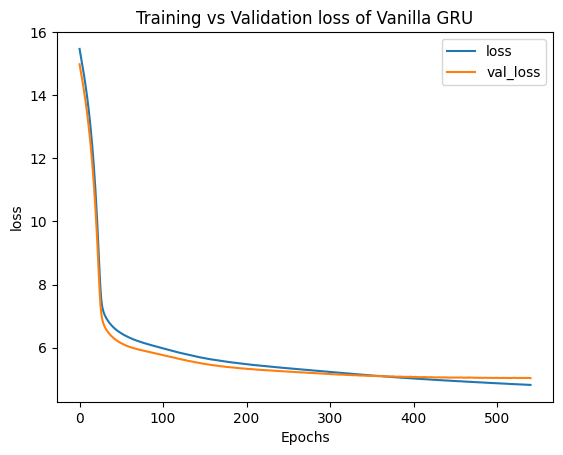

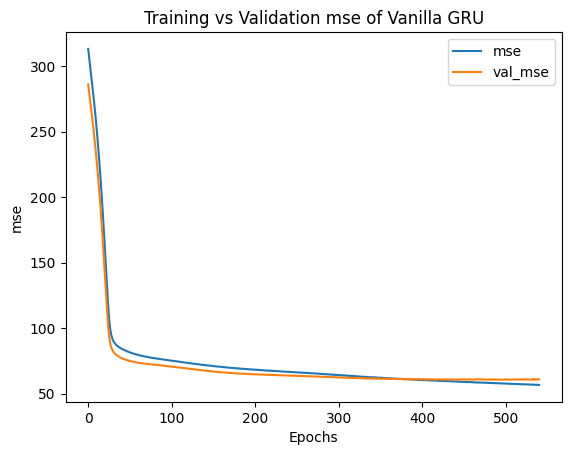

In [52]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyVanillaGRU, "loss")
plot_graphs(historyVanillaGRU, "mse")

## Prediction

### Prediction with training data

In [53]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [54]:
forecast_train_data = model_forecast(modelVanillaGRU, paxT3_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxT3_train_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 23ms/step

1681/1681 [==============================] - 3s 2ms/step
(1681, 24)
(1680,)
1680


In [55]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))
forecast_train_data[:5]

array([ 3.38833468,  1.83904497,  0.01375429, -0.80181272, -2.28795011])

In [56]:
actual = np.squeeze(paxT3_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680,)
[0 0 0 0 0]


In [57]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2023-04-02 00:00:00       0   3.388335
1    2023-04-02 01:00:00       0   1.839045
2    2023-04-02 02:00:00       0   0.013754
3    2023-04-02 03:00:00       0  -0.801813
4    2023-04-02 04:00:00       0  -2.287950
...                  ...     ...        ...
1675 2023-06-10 19:00:00      78  98.106085
1676 2023-06-10 20:00:00      76  95.471461
1677 2023-06-10 21:00:00      19  63.320447
1678 2023-06-10 22:00:00      28  19.712668
1679 2023-06-10 23:00:00       4   3.261538

[1680 rows x 3 columns]

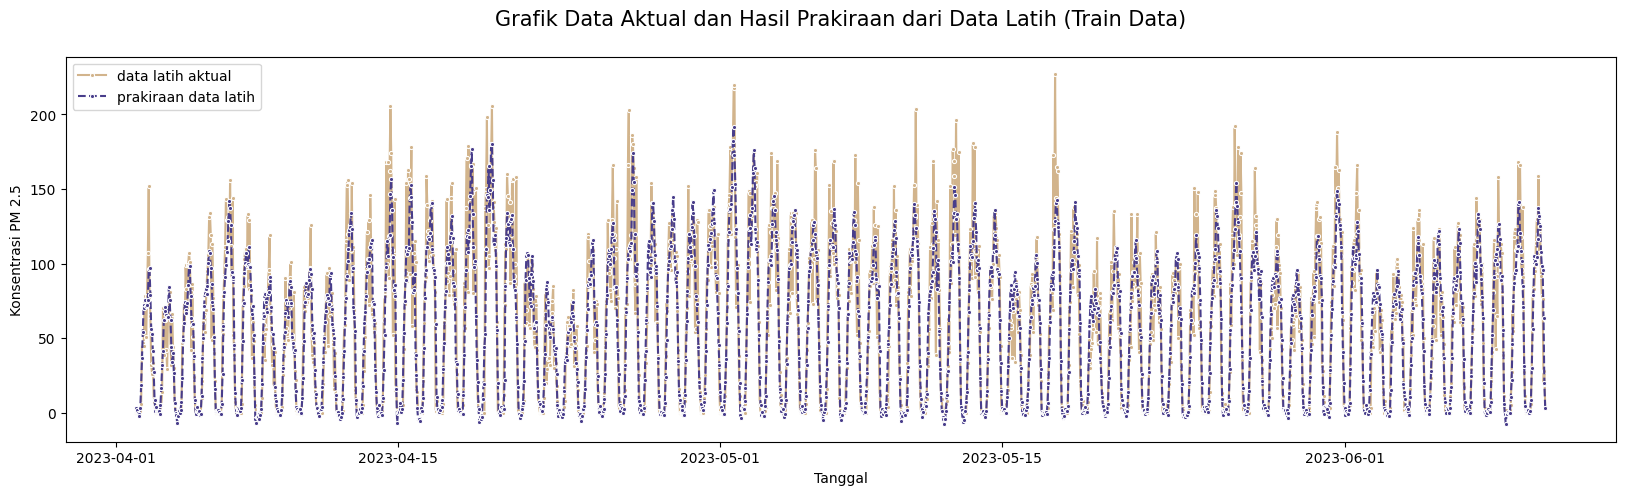

In [58]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [59]:
import plotly.express as px

df = px.data.stocks()
fig = px.line(df_train[-24:], x="Date", y=['Actual', 'Forecast'],
            #   hover_data={"Date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [60]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  21.12
MAE:  13.96
MAPE:  1.0759


### Prediction with validation data

In [61]:
forecast_val_data = model_forecast(modelVanillaGRU, paxT3_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxT3_val_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 23ms/step

769/769 [==============================] - 1s 2ms/step
(769, 24)
(768,)
768


In [62]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))
forecast_val_data[:5]

array([ 3.51975243, -0.60887535,  3.90625755,  3.2745208 , -1.13586052])

In [63]:
actual = np.squeeze(paxT3_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768,)
[0 0 0 0 0]


In [64]:
len(data_val[-forecast_val_data.shape[0]:])

768

In [65]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual   Forecast
0   2023-06-12 00:00:00       0   3.519752
1   2023-06-12 01:00:00       0  -0.608875
2   2023-06-12 02:00:00       0   3.906258
3   2023-06-12 03:00:00       0   3.274521
4   2023-06-12 04:00:00       0  -1.135861
..                  ...     ...        ...
763 2023-07-13 19:00:00     118  94.441830
764 2023-07-13 20:00:00     148  82.562237
765 2023-07-13 21:00:00      96  76.467192
766 2023-07-13 22:00:00      39  37.167475
767 2023-07-13 23:00:00      11  11.761642

[768 rows x 3 columns]

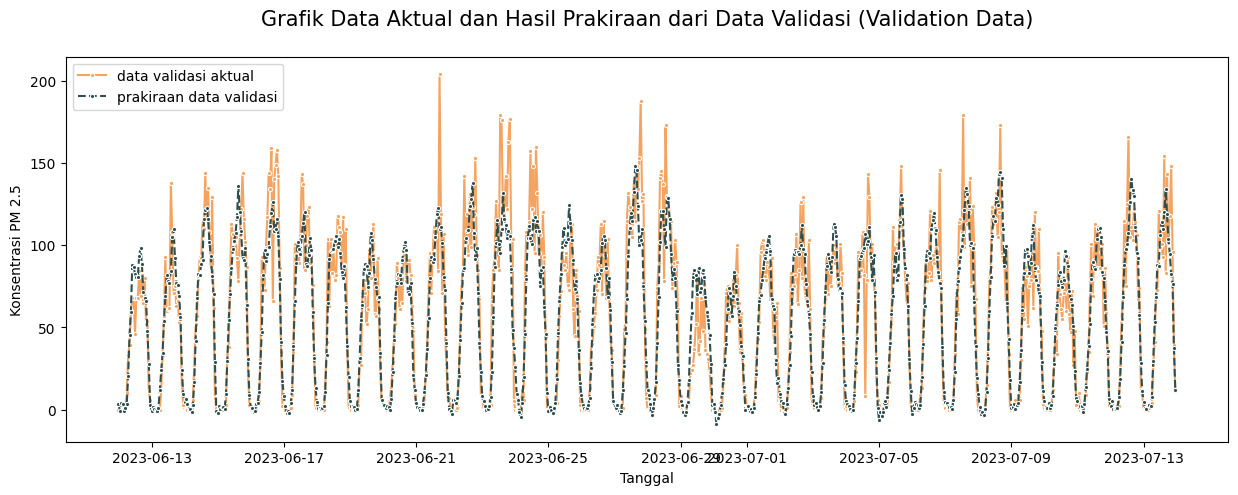

In [66]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [67]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  20.25
MAE:  13.85
MAPE:  0.6488


### Prediction with test data

In [68]:
forecast_test_data = model_forecast(modelVanillaGRU, paxT3_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxT3_test_scaled.shape[0]-n_lookback)

     50/Unknown - 0s 2ms/step

121/121 [==============================] - 0s 2ms/step
(121, 24)
(120,)
120


In [69]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))
forecast_test_data[:5]

array([ 9.9637714 , -1.91502804,  0.23366886,  1.86365085,  1.40309482])

In [70]:
actual = np.squeeze(paxT3_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120,)
[1 1 0 0 0]


In [71]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0   2023-07-15 00:00:00       1   9.963771
1   2023-07-15 01:00:00       1  -1.915028
2   2023-07-15 02:00:00       0   0.233669
3   2023-07-15 03:00:00       0   1.863651
4   2023-07-15 04:00:00       0   1.403095
..                  ...     ...        ...
115 2023-07-19 19:00:00      65  87.130111
116 2023-07-19 20:00:00      90  78.600700
117 2023-07-19 21:00:00      47  65.218032
118 2023-07-19 22:00:00      31  31.379564
119 2023-07-19 23:00:00       4   3.560348

[120 rows x 3 columns]

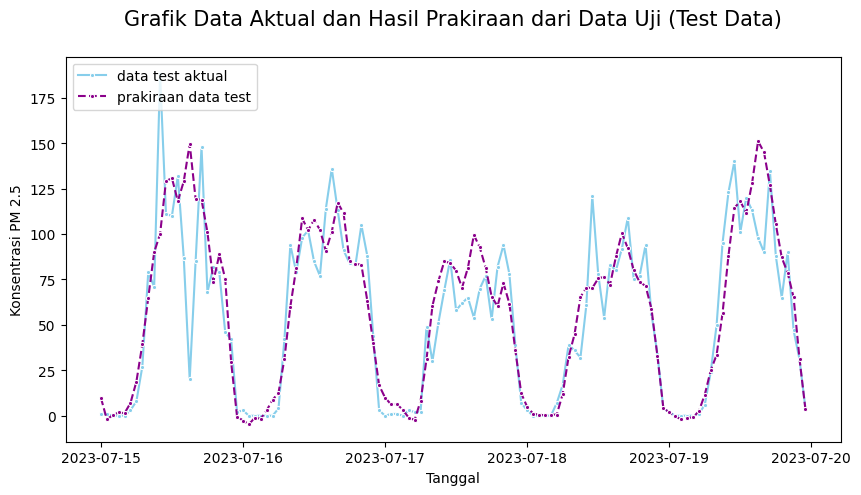

In [72]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [73]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  22.88
MAE:  14.55
MAPE:  0.5879


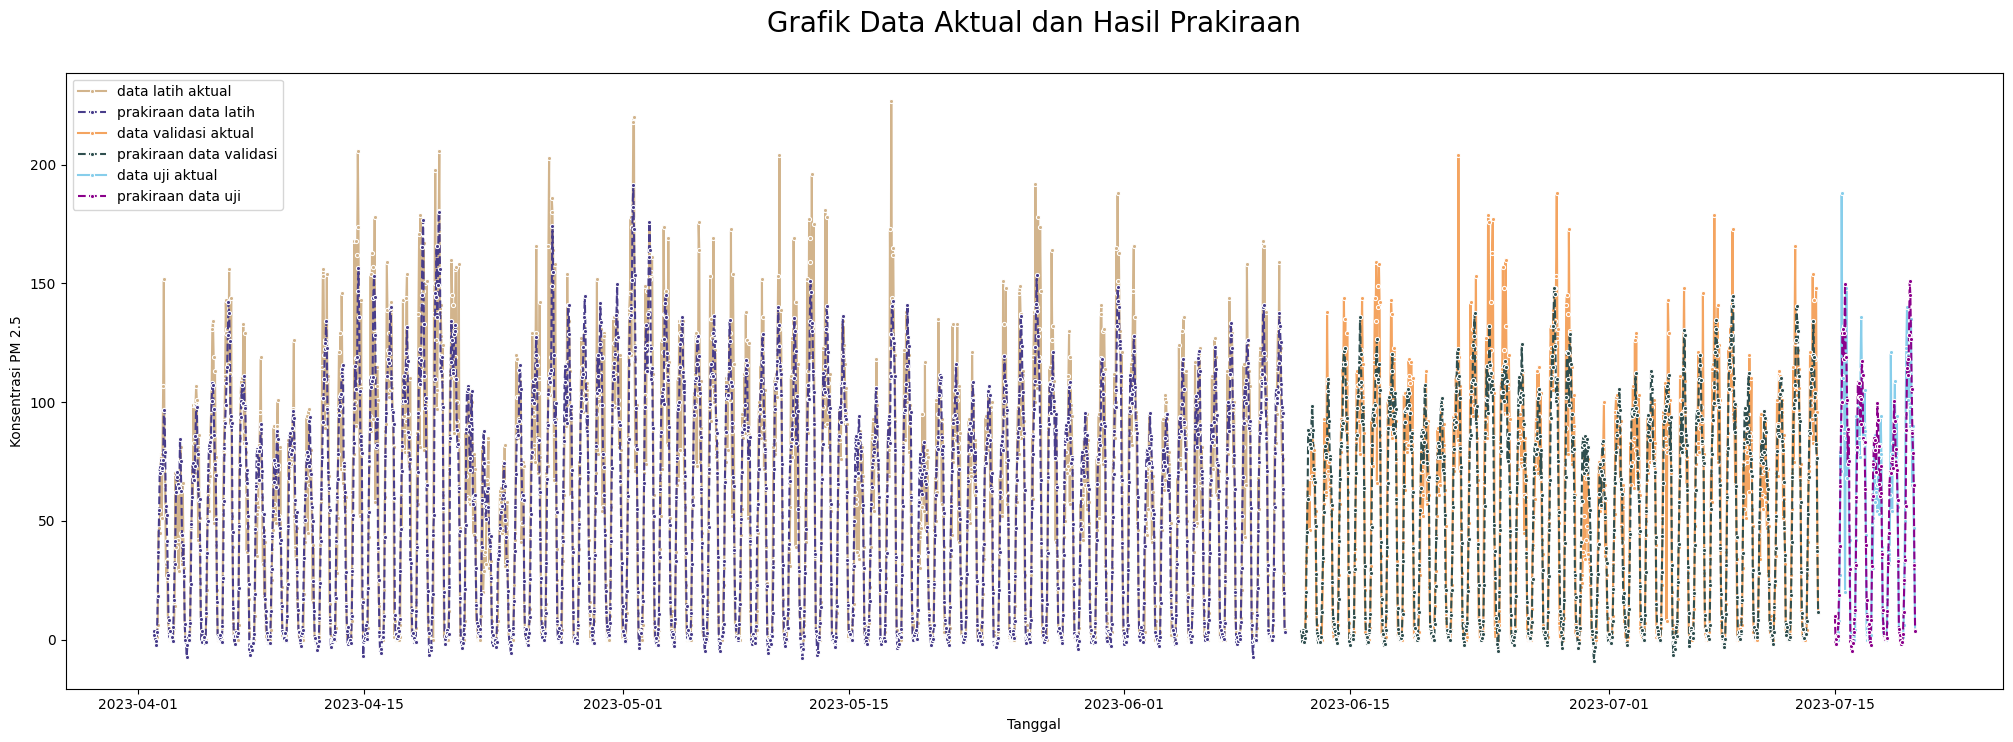

In [74]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')

# Bidirectional GRU

## generate model

In [76]:
modelBidirectionalGRU = Sequential([
        Bidirectional(GRU(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            ), input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast)
    ])

modelBidirectionalGRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 24, 128)          25728     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 24)                73752     
                                                                 
Total params: 99,480
Trainable params: 99,480
Non-trainable params: 0
_________________________________________________________________


In [77]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelBidirectionalGRU.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [78]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v2/BidirectionalGRU-Model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [79]:
historyBidirectionalGRU = modelBidirectionalGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000
51/52 [============================>.] - ETA: 0s - loss: 15.7961 - mse: 301.1830
Epoch 1: val_mse improved from inf to 270.55176, saving model to ./model v2\BidirectionalGRU-Model.h5
52/52 [==============================] - 3s 17ms/step - loss: 15.7874 - mse: 300.9427 - val_loss: 15.1848 - val_mse: 270.5518
Epoch 2/1000
52/52 [==============================] - ETA: 0s - loss: 15.3802 - mse: 286.2721
Epoch 2: val_mse improved from 270.55176 to 257.05475, saving model to ./model v2\BidirectionalGRU-Model.h5
52/52 [==============================] - 1s 12ms/step - loss: 15.3802 - mse: 286.2721 - val_loss: 14.7804 - val_mse: 257.0547
Epoch 3/1000
48/52 [==========================>...] - ETA: 0s - loss: 14.9962 - mse: 272.9356
Epoch 3: val_mse improved from 257.05475 to 243.75743, saving model to ./model v2\BidirectionalGRU-Model.h5
52/52 [==============================] - 1s 11ms/step - loss: 14.9705 - mse: 271.9635 - val_loss: 14.3703 - val_mse: 243.7574
Epoch 4/1000
47/52 [==

In [80]:
with open('./model v2/historyBidirectionalGRU', 'wb') as file_pi:
    pickle.dump(historyBidirectionalGRU.history, file_pi)

with open('./model v2/historyBidirectionalGRU', "rb") as file_pi:
    load_historyBidirectionalGRU = pickle.load(file_pi)

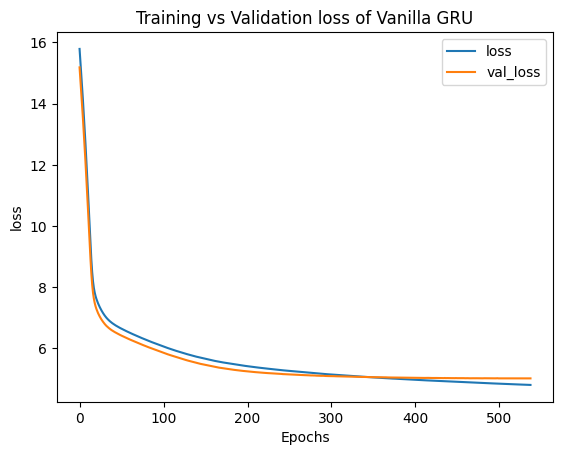

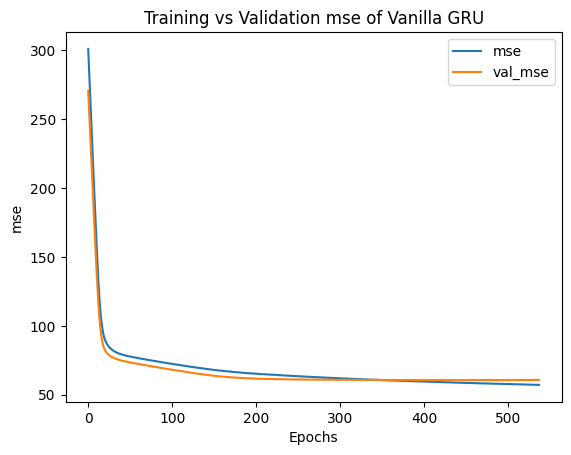

In [81]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyBidirectionalGRU, "loss")
plot_graphs(historyBidirectionalGRU, "mse")

## Prediction

### Prediction with training data

In [82]:
def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

In [83]:
forecast_train_data = model_forecast(modelBidirectionalGRU, paxT3_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxT3_train_scaled.shape[0]-n_lookback)

1681/1681 [==============================] - 5s 3ms/step
(1681, 24)
(1680,)
1680


In [84]:
forecast_train_data = inverse_normalize_series(forecast_train_data, Average(paxT3_train), stdev(convert_bit_lenght(paxT3_train)))
forecast_train_data[:5]

array([ 0.26021044, -1.04095991, -0.49426801, -2.01716764,  0.26917879])

In [85]:
actual = np.squeeze(paxT3_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680,)
[0 0 0 0 0]


In [86]:
df_train = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index
df_train['Forecast'] = forecast_train_data
df_train['Actual'] = actual
df_train

Date  Actual   Forecast
0    2023-04-02 00:00:00       0   0.260210
1    2023-04-02 01:00:00       0  -1.040960
2    2023-04-02 02:00:00       0  -0.494268
3    2023-04-02 03:00:00       0  -2.017168
4    2023-04-02 04:00:00       0   0.269179
...                  ...     ...        ...
1675 2023-06-10 19:00:00      78  79.854454
1676 2023-06-10 20:00:00      76  86.800536
1677 2023-06-10 21:00:00      19  63.423618
1678 2023-06-10 22:00:00      28  14.911162
1679 2023-06-10 23:00:00       4   1.904009

[1680 rows x 3 columns]

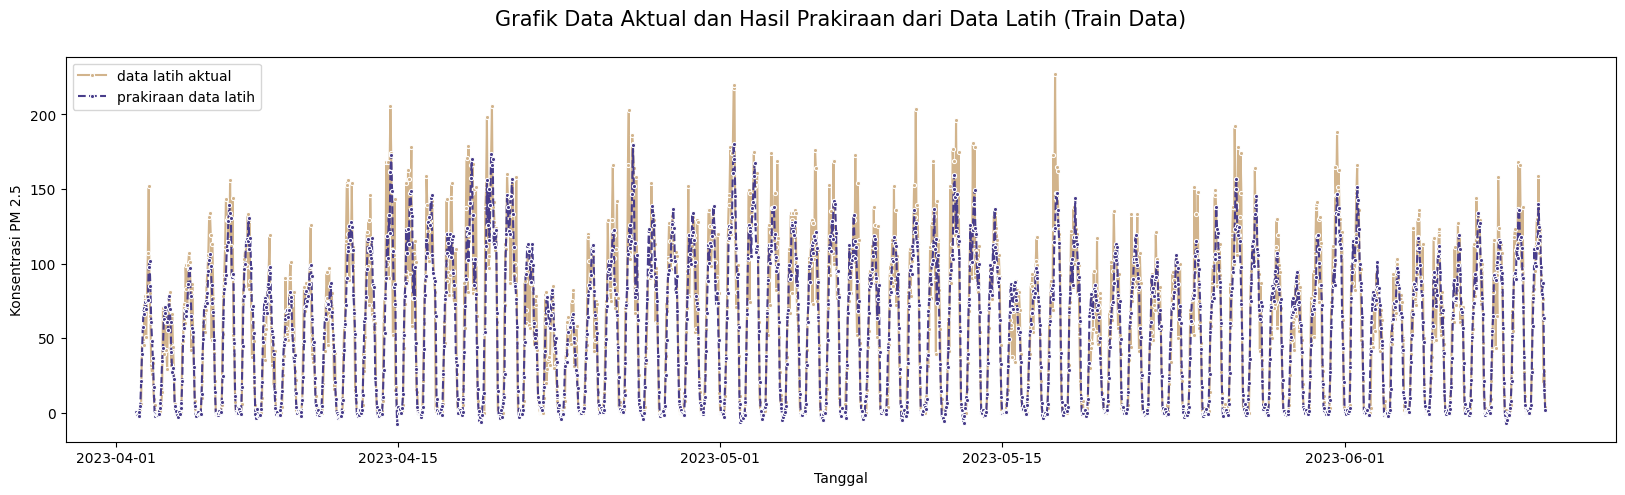

In [87]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [88]:
import plotly.express as px

df = px.data.stocks()
fig = px.line(df_train[-24:], x="Date", y=['Actual', 'Forecast'],
            #   hover_data={"Date": "|%B %d, %Y"},
              title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

In [89]:
rmse = mean_squared_error(df_train['Forecast'], df_train['Actual'], squared=False)
mae = mean_absolute_error(df_train['Forecast'], df_train['Actual'])
mape = mean_absolute_percentage_error(df_train['Forecast'], df_train['Actual'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Train accuracy
RMSE:  20.76
MAE:  13.63
MAPE:  0.8354


### Prediction with validation data

In [90]:
forecast_val_data = model_forecast(modelBidirectionalGRU, paxT3_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxT3_val_scaled.shape[0]-n_lookback)

     36/Unknown - 0s 3ms/step

769/769 [==============================] - 2s 3ms/step
(769, 24)
(768,)
768


In [91]:
forecast_val_data = inverse_normalize_series(forecast_val_data, Average(paxT3_val), stdev(convert_bit_lenght(paxT3_val)))
forecast_val_data[:5]

array([ 3.84570998e-01, -4.25625618e+00, -4.08423622e+00,  1.66556160e+00,
       -1.85401994e-03])

In [92]:
actual = np.squeeze(paxT3_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768,)
[0 0 0 0 0]


In [93]:
len(data_val[-forecast_val_data.shape[0]:])

768

In [94]:
df_val = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index
df_val['Forecast'] = forecast_val_data
df_val['Actual'] = actual
df_val

Date  Actual    Forecast
0   2023-06-12 00:00:00       0    0.384571
1   2023-06-12 01:00:00       0   -4.256256
2   2023-06-12 02:00:00       0   -4.084236
3   2023-06-12 03:00:00       0    1.665562
4   2023-06-12 04:00:00       0   -0.001854
..                  ...     ...         ...
763 2023-07-13 19:00:00     118  101.537769
764 2023-07-13 20:00:00     148   88.497806
765 2023-07-13 21:00:00      96   82.413702
766 2023-07-13 22:00:00      39   45.193623
767 2023-07-13 23:00:00      11   12.325237

[768 rows x 3 columns]

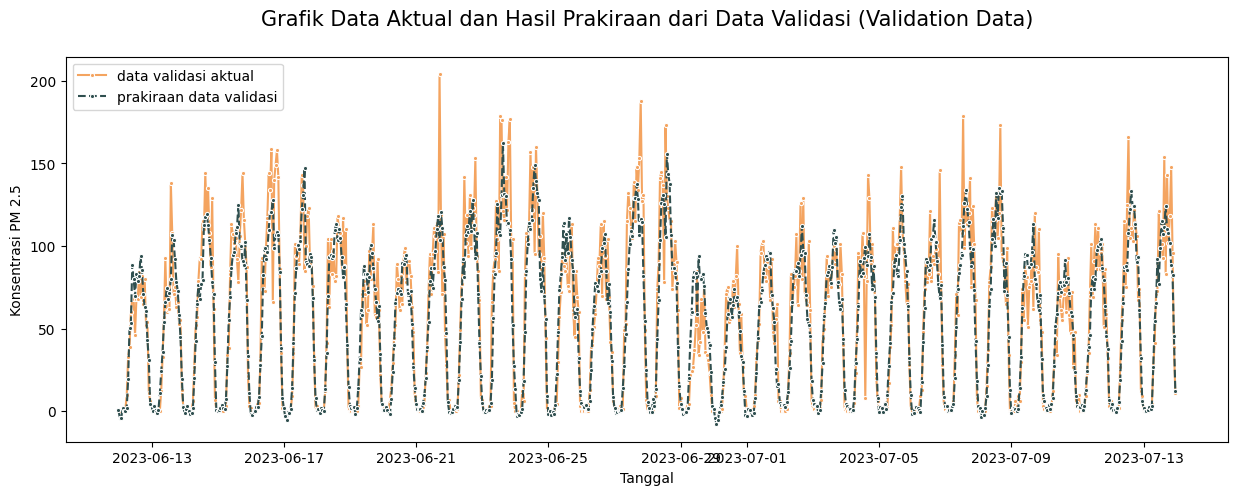

In [95]:
plt.subplots(figsize=(15, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Validasi (Validation Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [96]:
rmse = mean_squared_error(df_val['Forecast'], df_val['Actual'], squared=False)
mae = mean_absolute_error(df_val['Forecast'], df_val['Actual'])
mape = mean_absolute_percentage_error(df_val['Forecast'], df_val['Actual'])

print('Forecast Val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Val accuracy
RMSE:  19.86
MAE:  13.38
MAPE:  4.9019


### Prediction with test data

In [97]:
forecast_test_data = model_forecast(modelBidirectionalGRU, paxT3_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxT3_test_scaled.shape[0]-n_lookback)

      1/Unknown - 0s 23ms/step

121/121 [==============================] - 0s 3ms/step
(121, 24)
(120,)
120


In [98]:
forecast_test_data = inverse_normalize_series(forecast_test_data, Average(paxT3_test), stdev(convert_bit_lenght(paxT3_test)))
forecast_test_data[:5]

array([ 4.51449924, -1.07629055, -3.27994198,  2.34107547,  0.50064807])

In [99]:
actual = np.squeeze(paxT3_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120,)
[1 1 0 0 0]


In [100]:
df_test = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index
df_test['Forecast'] = forecast_test_data
df_test['Actual'] = actual
df_test

Date  Actual   Forecast
0   2023-07-15 00:00:00       1   4.514499
1   2023-07-15 01:00:00       1  -1.076291
2   2023-07-15 02:00:00       0  -3.279942
3   2023-07-15 03:00:00       0   2.341075
4   2023-07-15 04:00:00       0   0.500648
..                  ...     ...        ...
115 2023-07-19 19:00:00      65  89.894966
116 2023-07-19 20:00:00      90  80.577171
117 2023-07-19 21:00:00      47  64.635108
118 2023-07-19 22:00:00      31  30.363496
119 2023-07-19 23:00:00       4   3.571018

[120 rows x 3 columns]

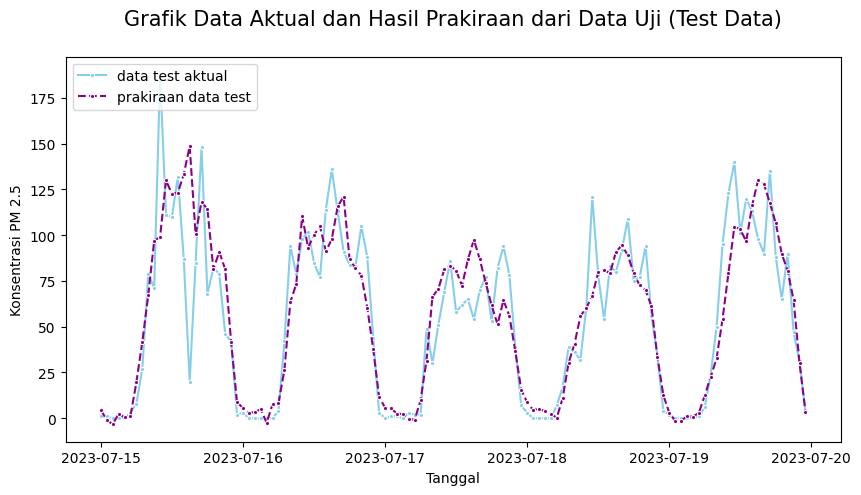

In [101]:
plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data test aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data test", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Uji (Test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [102]:
rmse = mean_squared_error(df_test['Forecast'], df_test['Actual'], squared=False)
mae = mean_absolute_error(df_test['Forecast'], df_test['Actual'])
mape = mean_absolute_percentage_error(df_test['Forecast'], df_test['Actual'])

print('Forecast Test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))
print('MAPE: ', round(mape,4))

Forecast Test accuracy
RMSE:  23.07
MAE:  14.64
MAPE:  0.8581


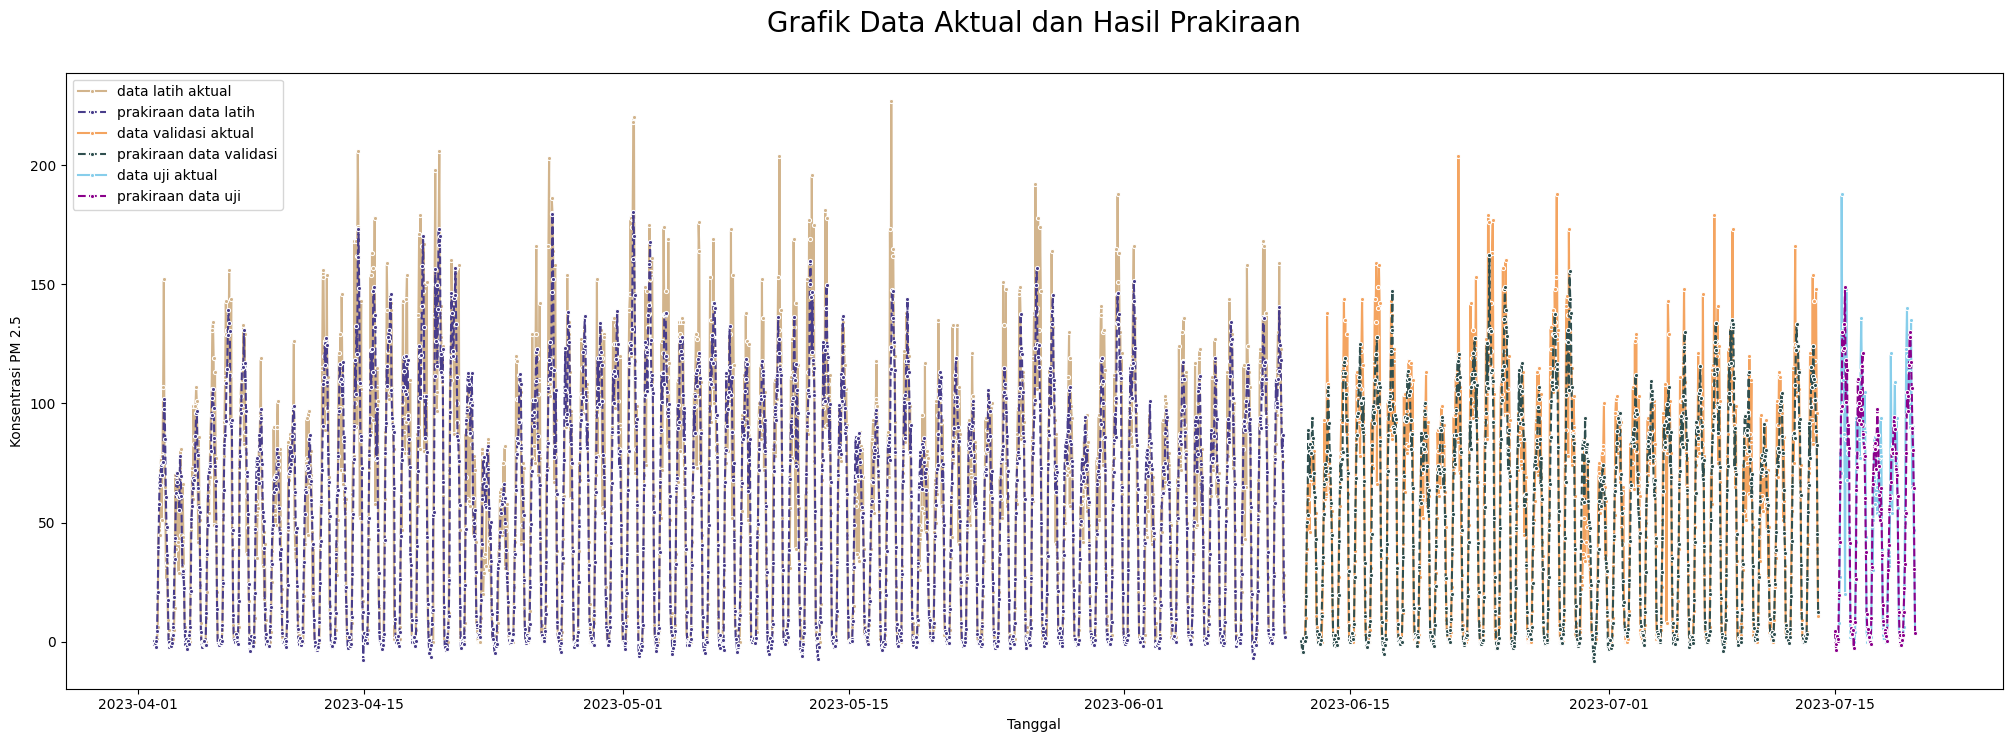

In [103]:
fig, ax = plt.subplots(figsize = (25,8)) 
ax = sns.lineplot(x="Date", y="Actual", data=df_train, 
                    label="data latih aktual", marker='.', color='tan')
ax = sns.lineplot(x="Date", y="Forecast", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color='darkslateblue')
ax = sns.lineplot(x="Date", y="Actual", data=df_val, 
                    label="data validasi aktual", marker='.', color='sandybrown')
ax = sns.lineplot(x="Date", y="Forecast", data=df_val, 
                    label="prakiraan data validasi", marker='.', linestyle="--", color='darkslategrey')
ax = sns.lineplot(x="Date", y="Actual", data=df_test,
                    label="data uji aktual", marker='.', color = 'skyblue')
ax = sns.lineplot(x="Date", y="Forecast", data=df_test, 
                    label="prakiraan data uji", marker='.', linestyle="--", color='darkmagenta')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan\n", fontsize = 20)
plt.legend(loc='upper left')